<a href="https://colab.research.google.com/github/leonSadowski/sc_Hierarchical_Classifier/blob/main/NN_class_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [406]:
import numpy as np 
import tensorflow as tf 
import tensorflow.keras as keras 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import networkx as nx

**Create Class for local (NN) classifier**

In [407]:
class Neural_Network():

  def __init__(self, 
               x_input_data,
               y_input_data,
               len_of_output, #NEU!!!!! ÜBERGEBE LÄNGE DES OUTPUT VEKTORS WEIL Y_INPUT für feinere Knoten KEIN PANDAS DATAFRAME MEHR IST
               z_transform_input = True,
               list_of_hidden_layer_nodes = [30],
               activation_function = 'relu',
               learning_rate = 0.001,
               momentum = .9,
               loss_function = 'categorical_crossentropy',
               epochs = 50):
    
    self.x_input_data = x_input_data
    self.y_input_data = y_input_data
    self.list_of_layer_nodes = [len(self.x_input_data[0])] + [nodes for nodes in list_of_hidden_layer_nodes] + [len_of_output] #[len(self.y_input_data.cat.categories)] 
    self.activation_function = activation_function 
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.loss_function = loss_function
    self.epochs = epochs
    self.z_transform_input = z_transform_input

    #create model

    self.model = keras.models.Sequential()

    for nodes, layer_idx in zip(self.list_of_layer_nodes, range(0, len(self.list_of_layer_nodes)-1)):

      self.model.add(keras.layers.Dense(
          input_shape = (nodes,),
          units = self.list_of_layer_nodes[layer_idx+1],                            
          kernel_initializer = 'glorot_uniform',                                          
          bias_initializer = 'zeros',                                               
          activation = self.activation_function if layer_idx == 0 else 'softmax'))  
        

  def process_input_data(self):

    #z transformation 

    def z_transform_properties(data_arr):
      '''Calculates a z transformation to center properties across cells in data_arr around mean zero'''
      
      mean_vals = np.mean(data_arr, axis=0)
      std_val = np.std(data_arr)

      data_transformed = (data_arr - mean_vals) / std_val

      return data_transformed


    if self.z_transform_input:
      self.x_input_data = z_transform_properties(self.x_input_data)
      
    #converting labels of y_input_data to integers (mapping 'label'->int)

    # ----> erstmal so vereinfacht, dass incoming y_data encoded wird -> ist wegen group_by_labels eh mit strings

    print(f'network y_input before encoding: {self.y_input_data}')

    self.label_encoder = LabelEncoder()
    self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # if isinstance(self.y_input_data, pd.Series):
    #   #encode categorical labels from pandas Series as integers
    #   self.label_encoder = LabelEncoder()
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data.values)

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == int: #so vereinfachen, dass einfach immer encoded wird. mit neuer 'pipeline' wird eh nur y_input mit strings weitergegeben
    #   self.y_input_data_int = self.y_input_data

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == str: #y_input kein dataframe mehr, sondern Liste wegen preprocessing!
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # else:

    #   print('Error: Invalid or unknown Data Type for Y Input data')

  

    #split data (TO DO: implement scikit.learn cross_val_score for k-fold cross validation)

    split_data_index = int(2/3 * len(self.x_input_data))

    self.x_training_input = self.x_input_data[ : split_data_index]
    self.y_training_input_int = self.y_input_data_int[ : split_data_index]

    self.x_test_input = self.x_input_data[split_data_index : ]
    self.y_test_input_int = self.y_input_data_int[split_data_index : ]

    #use integer y_input data for OneHot Encoding (int -> e_i element R^(int+1)) needed for model training

    self.y_training_onehot = keras.utils.to_categorical(self.y_training_input_int)
    self.y_test_onehot = keras.utils.to_categorical(self.y_test_input_int)


  def train(self):
    '''Train the NN using the x_training_data input and onehot encoded y_training_onehot'''

    self.optimizer = keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum)
    
    self.model.compile(optimizer = self.optimizer, loss = self.loss_function)

    history = self.model.fit(self.x_training_input, self.y_training_onehot,
                        batch_size = 64, epochs = self.epochs, 
                        verbose = 1,
                        validation_split = .1)
    
  def predict(self, input_vec):
    '''Calculate and return label prediction of trained model for an input vector
        input_vec (dtype=int)'''

    #returns only absolute decisions, nothing known about the difference in prediction confidence 
    pred_vec = np.argmax(self.model.predict(input_vec), axis = -1) #-1?

    return pred_vec


  def validate(self):

    self.y_training_preds = self.predict(self.x_training_input)
    self.y_test_preds = self.predict(self.x_test_input) 

    def calc_acc(pred_vec, known_vec):
      
      if type(pred_vec) == type(known_vec):
        acc = np.sum(pred_vec == known_vec, axis = 0) / len(known_vec)
      else:
        print('self.validate: Error! Comparison of different label encoding!')
      
      return acc
    
    # ---> save in node memory, not in classifier model
    # self.train_acc = calc_acc(self.y_training_preds, self.y_training_input_int) 
    # self.test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    train_acc = calc_acc(self.y_training_preds, self.y_training_input_int)
    test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    return train_acc, test_acc


  def master_method_NN(self, validate):
    '''method to run all relevant neural network methods, to be called from hierarchical classifier!
    not sure if needed'''
    
    # self.process_input_data()
    # self.train()

    #prediction vector soll in node_memory gespeichert werden!

    pass



    
    
  



**Class, which instances save relevant information for each node/local classifier**

In [408]:
class Node_Memory():

  def __init__(self, x_input_data = None, y_input_data = None, local_classifier = None, local_classifier_params = []):

      #local_classifier argument is the Class of classifier (eg Neural_Network (classifier specific params, input and output needed for every possible classifier))
      #initialize all needed attributes, but assign via HC objects

      self.x_input_data = x_input_data  #processing wird von local classifier übernommen (CAVE bei Verwendung anderer LC (eg SVM), dass preprocessing einheitlich ist)
      self.y_input_data = y_input_data 

      print(f'x_input_data from Node_Memory: {x_input_data}')

      self.y_input_grouped_labels = None  #is generated via Hierarchical classifier, maps all labels to labels of children of THIS node object

      self.apriori_y_input_data_indices = None #save indices of data in y_input vector, that will be used for prediction in order to compute accuracy
      
      #still manual splitting -> adjust to k fold CV in future
      self.training_prediction_vec = None
      self.test_prediction_vec = None

      self.training_acc = None
      self.test_acc = None

      #SEEEEEEEHR UNSCHÖÖÖÖÖÖN, PROBLEM MIT Y_INPUT_GROUPED_BY_LABELS_BEHEBEN!! DANN INITIALISIEREN WIEDER IN KONSTRUKTOR SCHREIBEN
      self.classifier_class = local_classifier #zwischenspeichern der Klasse bis y_input_grouped labels durch HC ausgegeben wurde --> SEHR UNSCHÖN
      self.local_classifier_params = local_classifier_params

  def initialize_local_classifier(self, local_classifier_output_len):
    print(f'zu übergebene y_input daten: {self.y_input_grouped_labels}')
    if self.classifier_class != None:
      self.local_classifier = self.classifier_class(self.x_input_data, self.y_input_grouped_labels, local_classifier_output_len, *self.local_classifier_params)  #use y_input with labels that refer to the child nodes
    else:
      #TO DO: bessere Lösung einfallen lassen
      print('WARNING! No classifier initialized!')

  #---> sollte eher auch von 'Oberklasse' ausgeführt werden
  #Methoden zur Ausführung des local classifiers eines parent nodes
    
  # def run_local_classifier(self):               
  #   self.local_classifier.train()
  
  #----> soll über hierarchical_classifier objekt aufgerufen werden
  # def local_classifier_prediction(self, input_vec): #hier muss noch was passieren, prediction von außen für bestimmte inputs aufrufen
  #   self.local_classifier.predict(input_vec)

**Class for hierarchical model with graph structure, local classifiers are attributes of graph nodes**

In [409]:
def make_graph_from_edges(d, g, parent_key=''):
    for key in d.keys():
        if parent_key != '':
            g.add_edge(parent_key, key)
        if len(d[key]) == 0:
            pass
        else:
            make_graph_from_edges(d[key], g, parent_key=key)

In [410]:
def list_subgraph_nodes(g, parent_node):
  list_of_nodes = []
  for node in g.adj[parent_node].keys():
    if len(g.adj[parent_node].keys()) != 0:
      list_of_nodes.append(node)
      list_of_nodes = list_of_nodes + list_subgraph_nodes(g, node)
    else:
      list_of_nodes.append(node)
  return list_of_nodes

In [411]:
class Hierarchical_Classifier():
  '''Class connects Nodes of Local Classifiers, passes results to children classifiers and forms the final hierarchical classifier''' 

  def __init__(self, dict_of_cell_relations):
    '''Params
        - dict_of_cell_relations: used for initializing network structure of hierarchical classifier'''
    self.dict_of_cell_relations = dict_of_cell_relations


  def make_classifier_graph(self):
    '''Compute Graph from a given dictionary of cell relationships'''
    self.graph = nx.DiGraph()
    make_graph_from_edges(self.dict_of_cell_relations, self.graph)

  def init_node_memory_object(self, node, memory_class_params=[]):
    '''Add memory object to each node; memory object organizes all relevant local classifier params'''
    self.graph.add_node(node, memory=Node_Memory(*memory_class_params)) #lade die relevanten Daten
    if len(memory_class_params) != 0: #auch sehr unschön ---> so ändern, dass konflit mit NN Initialisierung und berechnen von y_input_grouped_labels in node memory nicht auftritt
      self.group_labels_of_subgraph_to_parent_label(node) #schreibe die relevanten (komprimierten) y_input daten durch aufrufen der methode
      
      print(f'Aus init_node_memory_object von Knoten {node}: output größe initialisiert als {len(self.graph.adj[node].keys())}')
      
      self.graph.nodes[node]['memory'].initialize_local_classifier(len(self.graph.adj[node].keys())) #initialisiere den local_classifier (jetzt ist y_input_grouped_labels in node memory gegeben)
                                                                                                      #GEÄNDERT: ÜBERGEBE LÄNGE DES LETZTEN LAYERS DES NN, vorher aus cat.categories geschlossen
                                                                                                      #aber y_input_grouped_labels ist eine Liste
  def run_local_classifier(self, node):
    '''DEV METHOD: use for calling single methods at once to begin with'''
    
    #wo werden dem ersten local classifier die daten übergeben? --> aktuell manuell (s.u. TESTEN)

    #ONLY NEEDED FOR GLOBAL ACCURACY
    #save indices of known labels of daughter nodes in these corresponding nodes (i.e. eg node 'TNK' knows indices of 'TNK' in y_input_data of node 'all' ) 
    next_labels = [label for label in self.graph[node].keys()]
    for label in next_labels:
      self.graph.nodes[label]['memory'].apriori_y_input_data_indices = np.where(np.array(self.graph.nodes[node]['memory'].y_input_data) == label)

    #run needed local classifier methods to train model
    self.graph.nodes[node]['memory'].local_classifier.process_input_data()
    self.graph.nodes[node]['memory'].local_classifier.train()

    #predict trainings and test data (still splitted manually -> k fold cross validation) and save in corresponding node memory
    self.graph.nodes[node]['memory'].training_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_training_input)
    self.graph.nodes[node]['memory'].test_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_test_input)

    #validate model 
    self.graph.nodes[node]['memory'].training_acc, self.graph.nodes[node]['memory'].test_acc =  self.graph.nodes[node]['memory'].local_classifier.validate()


  def run_local_classifier_master(self, node, validate = True):
    '''run master method of local classifier'''
    pass


  #automatisches mapping der feineren labels zu den groberen durch iterieren über die Labels der subgraphen, ausführen über 
  #Hierarchical_Classifier in jedem Knoten --> als y_input_data in node_memory speichern
  #Ziel: mapping aus textzelle automatisieren, dafür: nimm 'Nachbarn' als nächste parentlabel, deren kinder müssen 
  #dann zu Nachbarn gemapped werden

  #benutze den graph, weil hier die ecken bereits klar sind, klarer als in gegebenem dictionary (dort müsste über keys von keys iteriert werden)

  def group_labels_of_subgraph_to_parent_label(self, super_node):
    '''Maps y_input_data labels to parent label (eg map (CD4 T, CD8 T, NK) -> (TNK) for all neighbors of given super_node (eg TNK, B, Others) of Graph g
      Params:
        - super_node: node at which local classifier has to be run
        
      Saves result in y_input_grouped_labels attribute of Node_memory of super_node''' 

    mapping_dict = {node : [child_node for child_node in list_subgraph_nodes(self.graph, node)] for node in self.graph.adj[super_node].keys() }

    print(f'mapping_dict from group_labels_.. method of node {super_node}: {mapping_dict} before checking for annotation depth')

    #check if some neighbor nodes have already achieved highest annotation depth (terminal nodes) and map those to itself
    for key in mapping_dict.keys():
      if mapping_dict[key] == []:
        mapping_dict[key] = key

    print(f'mapping_dict from group_labels_.. method of node {super_node}: {mapping_dict} after checking for annotation depth')



    mapper = {k:v for v,k in pd.Series(mapping_dict).explode().iteritems()} #write dict such that key and value are interchanged, then map; von StackOverFlow: letze antwort https://stackoverflow.com/questions/32262982/pandas-combining-multiple-categories-into-one
    print(f'mapper for node {super_node}: {mapper}')

    #check if some cells were mislead and throw them out (otherwise they are labelled nan which gives more output units for neural network than needed + might be problematic for training of NN if 
    #cells are used asa data which were initially wrong, but are mapped to an output category)
    #DOES NOT WORK FOR PREDICTION OF UNLABELED CELLS OF COURSE! OPTION TRAINING/PREDICTION MODE NEEDED!

    temp_y_input = self.graph.nodes[super_node]['memory'].y_input_data

    print(f'y_input of this node before checking for wrong labels: {temp_y_input[:200]} and its shape: {temp_y_input.shape}')

    
    idx_of_incorrectly_labelled_cells = []
    for cell_label, cell_idx in zip(self.graph.nodes[super_node]['memory'].y_input_data, range(0, len(self.graph.nodes[super_node]['memory'].y_input_data))):
      if cell_label not in mapper.keys():
        idx_of_incorrectly_labelled_cells.append(cell_idx)
    self.graph.nodes[super_node]['memory'].y_input_data = np.delete(self.graph.nodes[super_node]['memory'].y_input_data,idx_of_incorrectly_labelled_cells, axis = 0)
    self.graph.nodes[super_node]['memory'].x_input_data = np.delete(self.graph.nodes[super_node]['memory'].x_input_data,idx_of_incorrectly_labelled_cells, axis = 0)
    temp_y_input = self.graph.nodes[super_node]['memory'].y_input_data

    print(f'y_input of this node after checking for wrong labels: {temp_y_input[:200]} and its shape: {temp_y_input.shape}')

  

    self.graph.nodes[super_node]['memory'].y_input_grouped_labels = [mapper.get(k) for k in self.graph.nodes[super_node]['memory'].y_input_data]
    

  def subset_pred_vec(self, node):
    next_labels = [label for label in self.graph[node].keys()]
    #fuse training and test data predictions to one prediction in order to have more data for next node (use local variable)
    current_pred_vec = np.concatenate((self.graph.nodes[node]['memory'].training_prediction_vec, self.graph.nodes[node]['memory'].test_prediction_vec), axis = 0)
    current_pred_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(current_pred_vec)

    print(f'zusammengefügter pred_vec aus training und testdaten: {current_pred_vec[:500]}\n')
    temp_current_x_input = self.graph.nodes[node]['memory'].x_input_data
    temp_current_y_input = self.graph.nodes[node]['memory'].y_input_data

    print(f'shape der vektoren: current_pred_vec: {current_pred_vec.shape} \n x_input der aktuellen node: {temp_current_x_input.shape}, y_input der aktuellen node: {temp_current_x_input.shape}')

    for next_label in next_labels:

      print(f'label in subset_pred_vec: {next_label}')

      #following line decodes integer output of neural network to string labels (for test and training data -> prediction vecs now overwritten, might be appropriate to use local variable) in order to compare with names of following nodes (again encoded by following local classifier)
      # self.graph.nodes[node]['memory'].training_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(self.graph.nodes[node]['memory'].training_prediction_vec)
      # self.graph.nodes[node]['memory'].test_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(self.graph.nodes[node]['memory'].test_prediction_vec)
      # temp_idx_vec = np.where(np.array(self.graph.nodes[node]['memory'].prediction_vec) == next_label)
      
      temp_idx_vec = np.where(current_pred_vec == next_label)
      #problem: damit werden auch falsch gelabelte daten aus dem prediction vektor mitgenommen
      #---> beim group labels die indizes rausschmeißen, die falsch gelabeled wurden (MÜSSTE FÜR OVERALL ACCURACY BERÜCKSICHTIGT WERDEN!! bzw wird es eigentlich schon?)
      self.graph.nodes[next_label]['memory'].x_input_data = np.array(self.graph.nodes[node]['memory'].x_input_data)[temp_idx_vec]
      self.graph.nodes[next_label]['memory'].y_input_data = np.array(self.graph.nodes[node]['memory'].y_input_data)[temp_idx_vec]


  def master_method(self):
    '''method to run all relevant methods -> "one-click" initializing of hierarchical classifier (?)'''
    pass



**#######################################################**
**Messy Test bereich**

In [412]:
# hc.group_labels_of_subgraph_to_parent_label('all')

**Test of Local classifier class**

In [413]:
!pip install scanpy 


In [414]:
import scanpy as sc

In [415]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [416]:
adata = sc.read('drive/MyDrive/single_cell/processed/pbmc3k_level_1_scvi.h5ad')

In [417]:
adata.obs['leiden']

AAACATACAACCAC-1               CD8 T
AAACATTGAGCTAC-1                   B
AAACATTGATCAGC-1               CD4 T
AAACCGTGCTTCCG-1                  NK
AAACCGTGTATGCG-1    FCGR3A Monocytes
                          ...       
TTTCGAACTCTCAT-1      CD14 Monocytes
TTTCTACTGAGGCA-1                   B
TTTCTACTTCCTCG-1                   B
TTTGCATGAGAGGC-1                   B
TTTGCATGCCTCAC-1               CD4 T
Name: leiden, Length: 2638, dtype: category
Categories (8, object): ['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes',
                         'Dendritic', 'Megakaryocytes']

In [418]:
adata.obs['training_level_1']

AAACATACAACCAC-1          TNK
AAACATTGAGCTAC-1            B
AAACATTGATCAGC-1          TNK
AAACCGTGCTTCCG-1          TNK
AAACCGTGTATGCG-1    Myeloisch
                      ...    
TTTCGAACTCTCAT-1    Myeloisch
TTTCTACTGAGGCA-1            B
TTTCTACTTCCTCG-1            B
TTTGCATGAGAGGC-1            B
TTTGCATGCCTCAC-1          TNK
Name: training_level_1, Length: 2638, dtype: category
Categories (4, object): ['B', 'Myeloisch', 'Others', 'TNK']

x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None
x_input_data from Node_Memory: None


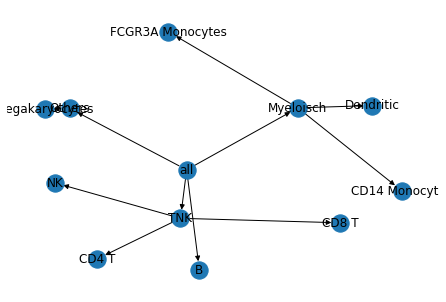

In [419]:
#neues erstellen des digraphs, for loop setzt alle node memories zurück
hc = Hierarchical_Classifier({'all': {'TNK':{'CD4 T':{}, 'CD8 T':{}, 'NK':{}}, 'Myeloisch':{'FCGR3A Monocytes': {}, 'Dendritic':{}, 'CD14 Monocytes':{}}, 'B': {}, 'Others':{'Megakaryocytes':{}}}})
hc.make_classifier_graph()
for node in hc.graph.nodes:
  hc.init_node_memory_object(node)
nx.draw(hc.graph, with_labels=True)

In [420]:
list_subgraph_nodes(hc.graph, 'Myeloisch')

['FCGR3A Monocytes', 'Dendritic', 'CD14 Monocytes']

In [421]:
#save input data and initialize first network in first node
hc.init_node_memory_object('all', [adata.obsm['X_scVI'], adata.obs['leiden'], Neural_Network])

x_input_data from Node_Memory: [[-8.2410008e-01 -4.4704255e-01 -4.0748629e-01 ...  1.5713328e+00
  -1.5464950e+00 -1.4017861e+00]
 [ 1.6846647e+00  1.5554001e+00  1.4539602e+00 ...  8.6505902e-01
   2.4610202e-01 -6.0205215e-01]
 [-1.9270294e+00 -8.9073777e-03  9.7932434e-01 ... -6.7529649e-01
   2.8452635e-01 -3.1107724e-02]
 ...
 [ 1.7275798e+00  1.5300920e+00 -3.5907480e-01 ...  5.2253544e-01
  -9.2591718e-04  5.8562118e-01]
 [ 2.0938647e-01 -1.8596342e-01 -6.2905848e-01 ... -8.6578712e-02
  -2.9944363e-01  6.0269815e-01]
 [-7.3548514e-01 -2.7967069e-02 -2.4904236e-01 ...  5.8232641e-01
  -2.8247118e-01 -2.6726872e-01]]
mapping_dict from group_labels_.. method of node all: {'TNK': ['CD4 T', 'CD8 T', 'NK'], 'Myeloisch': ['FCGR3A Monocytes', 'Dendritic', 'CD14 Monocytes'], 'B': [], 'Others': ['Megakaryocytes']} before checking for annotation depth
mapping_dict from group_labels_.. method of node all: {'TNK': ['CD4 T', 'CD8 T', 'NK'], 'Myeloisch': ['FCGR3A Monocytes', 'Dendritic', 'CD1

In [422]:
#all set up - run local classifier
hc.run_local_classifier('all')

network y_input before encoding: ['TNK', 'B', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'B', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'B', 'B', 'B', 'TNK', 'Myeloisch', 'B', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'B', 'Myeloisch', 'TNK', 'Myeloisch', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'B', 'Myeloisch', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'Myeloisch', 'TNK', 'B', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'B', 'TNK', 'TNK', 'B', 'B', 'TNK', 'Myeloisch', 'B', 'B', 'Myeloisch', 'Myeloisch', 'TNK', 'Myeloisch', 'Myeloisch', 'Myeloisch', 'Myeloisch', 'Myeloisch', 'TNK', 'TNK', 'Myeloisch', 'B', 'TNK', 'B', 'TNK', 'Myeloisch', 'Myeloisch', 'TNK', 'TNK', 'TNK', 'Myeloisch', 'TNK', 'TNK', 'B', 

In [423]:
#print first level classifier model accuracy
print(hc.graph.nodes['all']['memory'].training_acc)

print(hc.graph.nodes['all']['memory'].test_acc)

0.9294653014789533
0.9181818181818182


In [424]:
hc.graph.nodes['all']['memory'].local_classifier.label_encoder.inverse_transform(hc.graph.nodes['all']['memory'].training_prediction_vec)

array(['TNK', 'B', 'TNK', ..., 'TNK', 'B', 'TNK'], dtype='<U9')

In [425]:
hc.subset_pred_vec('all')

zusammengefügter pred_vec aus training und testdaten: ['TNK' 'B' 'TNK' 'Myeloisch' 'Myeloisch' 'TNK' 'TNK' 'TNK' 'B' 'Myeloisch'
 'B' 'TNK' 'TNK' 'Myeloisch' 'TNK' 'TNK' 'Myeloisch' 'TNK' 'B' 'B' 'B'
 'TNK' 'Myeloisch' 'B' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'B'
 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'TNK' 'TNK' 'TNK'
 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'Myeloisch' 'TNK' 'TNK' 'Myeloisch'
 'TNK' 'TNK' 'TNK' 'TNK' 'B' 'Myeloisch' 'TNK' 'Myeloisch' 'Myeloisch'
 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK' 'TNK'
 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'B' 'TNK' 'TNK' 'TNK' 'Myeloisch'
 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'TNK' 'TNK' 'B' 'B'
 'TNK' 'Myeloisch' 'B' 'B' 'Myeloisch' 'Myeloisch' 'TNK' 'Myeloisch'
 'Myeloisch' 'Myeloisch' 'Myeloisch' 'Myeloisch' 'TNK' 'TNK' 'Myeloisch'
 'B' 'TNK' 'B' 'TNK' 'Myeloisch' 'Myeloisch' 'TNK' 'Myeloisch' 'TNK' 'TNK'
 'TNK' 'TNK' 'B' 'TNK' 'TNK' 'TNK' 'Myeloisch' 'B' 'TNK' 'TNK' 'TNK'
 'Myeloisch' 'B

In [426]:
hc.graph.nodes['TNK']['memory'].__dict__

{'apriori_y_input_data_indices': (array([], dtype=int64),),
 'classifier_class': None,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': array([[-0.8241001 , -0.44704255, -0.4074863 , ...,  1.5713328 ,
         -1.546495  , -1.4017861 ],
        [-1.9270294 , -0.00890738,  0.97932434, ..., -0.6752965 ,
          0.28452635, -0.03110772],
        [-0.67081773, -0.9181075 , -0.8583566 , ...,  2.500195  ,
         -0.4206484 ,  1.1639605 ],
        ...,
        [-0.56132644, -1.4612188 ,  1.6581316 , ..., -0.7799555 ,
         -0.3130556 , -1.748054  ],
        [-1.5681272 ,  1.3090951 ,  0.6303377 , ..., -1.2559723 ,
          0.4473528 ,  0.57438225],
        [-0.73548514, -0.02796707, -0.24904236, ...,  0.5823264 ,
         -0.28247118, -0.26726872]], dtype=float32),
 'y_input_data': array(['CD8 T', 'CD4 T', 'CD4 T', ..., 'CD8 T', 'CD4 T', 'CD4 T'],
       dtype=object),
 'y_input_g

In [427]:
#zeigt input vektor bevor falsche zellen herausgeworfen wurden
hc.graph.nodes['TNK']['memory'].y_input_data[0:100]

array(['CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T',
       'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK',
       'CD4 T', 'CD4 T', 'NK', 'CD8 T', 'CD8 T', 'CD4 T', 'NK', 'CD4 T',
       'FCGR3A Monocytes', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'NK', 'NK', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'FCGR3A Monocytes', 'NK', 'CD4 T', 'NK',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'B', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD14 Monocytes', 'NK', 'CD4 T', 'NK', 'CD4 T', 'CD8 T',
       'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T',
       'FCGR3A Monocytes', 'CD8 T', 'CD8 T', 'CD4 T', 'CD8 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T',
       'CD8 

In [428]:
#nun einmal alles für den tnk node 
#NN classifier initialisieren, hier noch unnötige Übergabe von input Daten, die er schon hat -> anders lösen, anderen Default, oder anderes initialisieren
hc.init_node_memory_object('TNK', [hc.graph.nodes['TNK']['memory'].x_input_data, hc.graph.nodes['TNK']['memory'].y_input_data, Neural_Network])

x_input_data from Node_Memory: [[-0.8241001  -0.44704255 -0.4074863  ...  1.5713328  -1.546495
  -1.4017861 ]
 [-1.9270294  -0.00890738  0.97932434 ... -0.6752965   0.28452635
  -0.03110772]
 [-0.67081773 -0.9181075  -0.8583566  ...  2.500195   -0.4206484
   1.1639605 ]
 ...
 [-0.56132644 -1.4612188   1.6581316  ... -0.7799555  -0.3130556
  -1.748054  ]
 [-1.5681272   1.3090951   0.6303377  ... -1.2559723   0.4473528
   0.57438225]
 [-0.73548514 -0.02796707 -0.24904236 ...  0.5823264  -0.28247118
  -0.26726872]]
mapping_dict from group_labels_.. method of node TNK: {'CD4 T': [], 'CD8 T': [], 'NK': []} before checking for annotation depth
mapping_dict from group_labels_.. method of node TNK: {'CD4 T': 'CD4 T', 'CD8 T': 'CD8 T', 'NK': 'NK'} after checking for annotation depth
mapper for node TNK: {'CD4 T': 'CD4 T', 'CD8 T': 'CD8 T', 'NK': 'NK'}
y_input of this node before checking for wrong labels: ['CD8 T' 'CD4 T' 'CD4 T' 'CD4 T' 'CD8 T' 'CD4 T' 'CD4 T' 'CD8 T' 'CD4 T'
 'CD4 T' 'CD4 T' 

In [429]:
hc.run_local_classifier('TNK')

network y_input before encoding: ['CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'CD4 T', 'CD4 T', 'NK', 'CD8 T', 'CD8 T', 'CD4 T', 'NK', 'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'NK', 'NK', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'CD4 T', 'NK', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'CD4 T', 'NK', 'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK', 'CD4 T', 'NK', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD8 T', 'CD8 T', 'CD8 T', 'CD

In [430]:
#accuracy of tnk classifier model 
print(hc.graph.nodes['TNK']['memory'].training_acc)

print(hc.graph.nodes['TNK']['memory'].test_acc)

0.936046511627907
0.9284332688588007


In [431]:
#show saved prediction results in next labels, <- hm ne das wird erst später aufgerufen
hc.graph.nodes['CD4 T']['memory'].__dict__

{'apriori_y_input_data_indices': (array([   1,    2,    3, ..., 1545, 1547, 1548]),),
 'classifier_class': None,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': None,
 'y_input_data': None,
 'y_input_grouped_labels': None}

In [432]:
#show status of node Myeloische Zellen
hc.graph.nodes['Myeloisch']['memory'].__dict__

{'apriori_y_input_data_indices': (array([], dtype=int64),),
 'classifier_class': None,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': array([[-0.65018964,  0.5909275 ,  0.17820597, ...,  0.7609098 ,
         -0.9427402 ,  1.1240003 ],
        [ 1.3202016 ,  0.6382091 , -1.6076678 , ..., -1.3887111 ,
         -0.43054047, -1.2502768 ],
        [ 0.03016484, -0.13684195,  0.38049364, ..., -0.8243723 ,
         -0.4725106 ,  0.7852393 ],
        ...,
        [ 0.00502422,  0.18570839,  0.38839135, ..., -0.05192301,
         -1.1637948 ,  1.4046977 ],
        [ 1.5008779 , -0.13873322, -0.09292659, ...,  0.1126502 ,
         -1.7490447 ,  1.5059206 ],
        [ 0.57691723, -0.09258436,  0.77182037, ..., -0.11639237,
          0.35169557,  1.8422029 ]], dtype=float32),
 'y_input_data': array(['NK', 'FCGR3A Monocytes', 'NK', 'CD14 Monocytes', 'CD14 Monocytes',
        'CD14 Monocytes',

In [433]:
#initialisieren des local classifiers für den Myeloisch node
hc.init_node_memory_object('Myeloisch', memory_class_params=[hc.graph.nodes['Myeloisch']['memory'].x_input_data, hc.graph.nodes['Myeloisch']['memory'].y_input_data, Neural_Network])

x_input_data from Node_Memory: [[-0.65018964  0.5909275   0.17820597 ...  0.7609098  -0.9427402
   1.1240003 ]
 [ 1.3202016   0.6382091  -1.6076678  ... -1.3887111  -0.43054047
  -1.2502768 ]
 [ 0.03016484 -0.13684195  0.38049364 ... -0.8243723  -0.4725106
   0.7852393 ]
 ...
 [ 0.00502422  0.18570839  0.38839135 ... -0.05192301 -1.1637948
   1.4046977 ]
 [ 1.5008779  -0.13873322 -0.09292659 ...  0.1126502  -1.7490447
   1.5059206 ]
 [ 0.57691723 -0.09258436  0.77182037 ... -0.11639237  0.35169557
   1.8422029 ]]
mapping_dict from group_labels_.. method of node Myeloisch: {'FCGR3A Monocytes': [], 'Dendritic': [], 'CD14 Monocytes': []} before checking for annotation depth
mapping_dict from group_labels_.. method of node Myeloisch: {'FCGR3A Monocytes': 'FCGR3A Monocytes', 'Dendritic': 'Dendritic', 'CD14 Monocytes': 'CD14 Monocytes'} after checking for annotation depth
mapper for node Myeloisch: {'FCGR3A Monocytes': 'FCGR3A Monocytes', 'Dendritic': 'Dendritic', 'CD14 Monocytes': 'CD14 Mon

In [434]:
hc.run_local_classifier('Myeloisch')

network y_input before encoding: ['FCGR3A Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'Dendritic', 'FCGR3A Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'Dendritic', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'Dendritic', 'CD14 Monocytes', 'CD14 Monocytes', 'Dendritic', 'CD14 Monocytes', 'FCGR3A Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'FCGR3A Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'CD14 Monocytes', 'FCGR3

In [435]:
#accuracy of myeloic classifier model 
print(hc.graph.nodes['Myeloisch']['memory'].training_acc)

print(hc.graph.nodes['Myeloisch']['memory'].test_acc)

0.946236559139785
0.93048128342246


Aktuell implementierte Objektauswahl macht Durchführung der Klassifizierung für 'Others' Knoten mit nur einem Tochterknoten sinnlos -> bräuchte direkte Ausgabe der softmax Aktivierungsfunktion um Wahrscheinlichkeiten auszugeben und dann eine confidence based entscheidung anstelle von auswahl des höchsten wertes (wäre dann immer eben der eine zur Wahl stehende Tochterknoten)

In [30]:
# nn_tnk.model.summary()